$\newcommand{\mr}[1]{\mathrm{#1}}$ 
$\newcommand{\bmr}[1]{\mathit{\mathbf{#1}}}$ 
$\newcommand{\tr}{^\mathrm{T}}$
$\newcommand{\lbr}{\left\lbrace}$
$\newcommand{\rbr}{\right\rbrace}$
$\newcommand{\dd}{\mathrm{d}}$
$\newcommand{\jj}{\mathrm{j}}$

## <center> Pomoćne funkcije
Interaktivni grafici koriste Python modul mpld3, koji se može instalirati komandom
    
    
    conda install mpld3
    
Primeri rade i ukoliko modul mpld3 nije instaliran, ali grafici neće biti interaktivni.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 je instaliran.")
except:
    print("Modul mpld3 nije instaliran.")
    
def plotSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),np.fft.fftshift(abs(np.fft.fft(x))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
        
def plotSpectrumdB(x, xlabel = "", ylabel="", title='', limit = -80, show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),20*np.log10(np.fft.fftshift(abs(np.fft.fft(x)))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.ylim(limit);

    if show:
        plt.show()
    
def stemSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    plt.stem(F, X)#, use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def plotSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.plot(x);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def stemSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.stem(x)# ,use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
    

Modul mpld3 nije instaliran.


In [2]:
import math


###############
# Functions
###############

def CORDIC_iteration(x, y, z, i, mode, scaled=False):
    """
    Calculate one iteration of CORDIC algorithm.
    x, y, z - inputs
    i - iteration number
    mode - "rotation" for CORDIC in rotation mode,
            otherwise calculates in vector mode
    scaled - True or False. If False, scaling factor is 1.
    Returns (x, y, z)
    """
    sgn = lambda a: (a>=0) - (a<0)
    if mode=="rotation":
        sigma = sgn(z)
    else:
        sigma = -sgn(y)
    xnew = x - sigma*y*2**(-i)
    ynew = y + sigma*x*2**(-i)
    z = z - sigma * math.atan(2**(-i))
    if scaled:
        ki = CORDIC_Ki(i)
        xnew *= ki
        ynew *= ki
    return (xnew, ynew, z)

def CORDIC_Ki(i):
    """
    Calculate the scaling factor for i-th iteration
    """
    k = 1.0/math.sqrt(1.0+2.0**(-2*i))
    return k

def CORDIC_Kn(n):
    """
    Calculate the overall scaling factor for n iterations
    """
    k = 1
    for i in range(0,n):
        k *= CORDIC_Ki(i)
    return k

def print_iteration(i, x, y, z):
    """
    Print intermediate results
    """
    res = '{0: <3}'.format(str(i))
    res += "{:12.8f} {:12.8f} {:12.8f}".format(x,y,z) 
    print(res)

In [3]:
def readSamples(fileName):
    samples = []
    inFile = open(fileName, "r")
    for line in inFile:
        samples.append( complex(line) )
    return np.array(samples)

1024


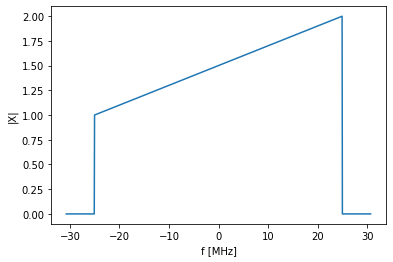

In [4]:
fs = 61.44e6
testsignal = readSamples("testsignal.txt")
N = len(testsignal)
print(N)
freqs = (np.arange(N)/N - 0.5) * fs/1e6
plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(testsignal))))
plt.xlabel("f [MHz]")
plt.ylabel("|X|");

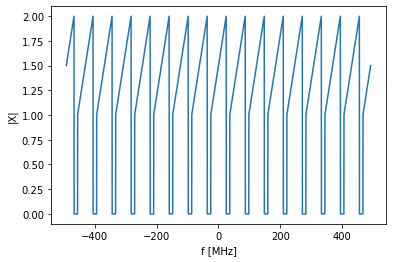

In [5]:
M = 16
oversampled_signal = np.zeros(len(testsignal)*M,dtype=complex) # argument dtype=complex je obavezan!
oversampled_signal[::M] = testsignal
freqs = (np.arange(N*M)/(N*M) - 0.5) * M*fs/1e6
plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(oversampled_signal))))
plt.xlabel("f [MHz]")
plt.ylabel("|X|");


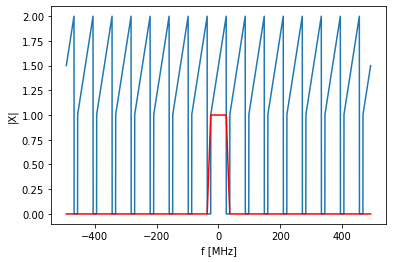

In [6]:
from remezlp import *

fmax = 25.0e6
fs = 61.44e6

Fpass = fmax/fs / M
Fstop = ((fs/2 -fmax)*2 + fmax)/fs/M
AdB = 60.0
Amax = 20.0*np.log10(1.0+10.0**(-AdB/20.0))
Amin = 20.0*np.log10(1.0-10.0**(-AdB/20.0))

deltaPass = 10.0**(-AdB/20.0)
deltaStop = deltaPass

plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(oversampled_signal))))
plt.plot([-M*fs/2/1e6, -M*Fstop*fs/1e6, -M*Fpass*fs/1e6, M*Fpass*fs/1e6, M*Fstop*fs/1e6, M*fs/2/1e6],[0, 0, 1, 1, 0, 0], 'r')
plt.xlabel("f [MHz]")
plt.ylabel("|X|");

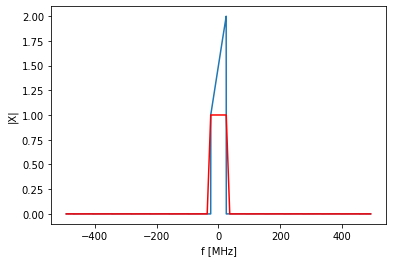

In [7]:
h = remezlp( Fpass, Fstop, deltaPass, deltaStop, nPoints=8192*8,Nmax=500)
# Test signal se periodicno produzava za len(h)/2 odbiraka, koliko iznosi kasnjenje filtra.
oversampled_signal_perext = np.concatenate((oversampled_signal, oversampled_signal[0:int(len(h/2))]))
xi = signal.lfilter(h, 1, oversampled_signal_perext)
xi = xi[len(h):]
plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(xi))))
plt.plot([-M*fs/2/1e6, -M*Fstop*fs/1e6, -M*Fpass*fs/1e6, M*Fpass*fs/1e6, M*Fstop*fs/1e6, M*fs/2/1e6],[0, 0, 1, 1, 0, 0], 'r')
plt.xlabel("f [MHz]")
plt.ylabel("|X|");

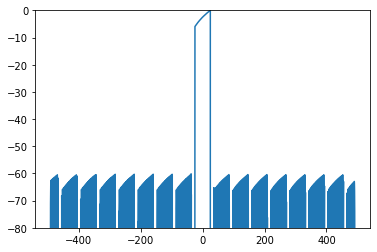

In [8]:
XdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xi))))
plt.plot(freqs, XdB-np.max(XdB))
plt.ylim(-80,0);

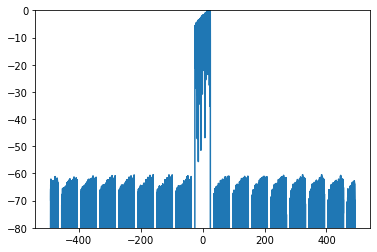

In [9]:
XdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xi* signal.hann(len(xi),'periodic')))))
plt.plot(freqs, XdB-np.max(XdB))
plt.ylim(-80,0);

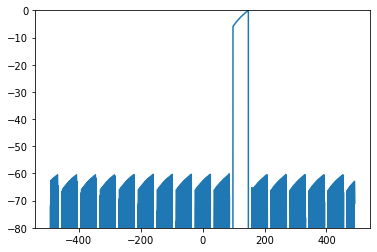

In [10]:
f0 = M*fs*3/8
f0 = M*fs*1/8
Omega0 = 2 * np.pi * f0/(M*fs)
n = np.arange(len(xi))
cplx_sine = np.exp(1j * n * Omega0)
#cplx_sine = np.round(np.exp(1j * n * Omega0), 3) # konacna tacnost CORDIC-a
xi_shifted = xi * cplx_sine
#xi_shifted = np.round(xi * cplx_sine, 3) # konacna tacnost duzine binarne reci
XdB_shifted = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xi_shifted))))
plt.plot(freqs, XdB_shifted-np.max(XdB_shifted))
plt.ylim(-80,0);

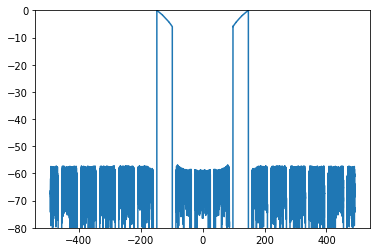

In [11]:
xr = xi_shifted.real
#XrdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xr* signal.hann(len(xi),'periodic')))))
XrdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xr))))
plt.plot(freqs, XrdB-np.max(XrdB))
plt.ylim(-80,0);

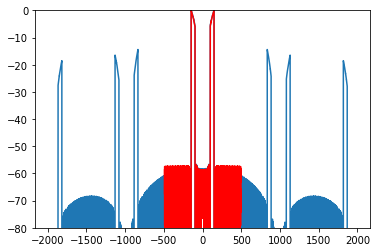

In [12]:
NyqZones = 4
nrz = np.ones(NyqZones)
xr_upsampled = np.zeros((len(xr)-1)*NyqZones+1)
xr_upsampled[::NyqZones] = xr
xr_nrz = np.convolve(nrz, xr_upsampled)
XrnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xr_nrz))))
freqs_nrz = (np.arange(N*M*len(nrz))/(N*M*len(nrz)) - 0.5) * M*fs*len(nrz)/1e6
plt.plot(freqs_nrz, XrnrzdB-np.max(XrnrzdB))
plt.plot(freqs, XrdB-np.max(XrdB),'r')
plt.ylim(-80,0);

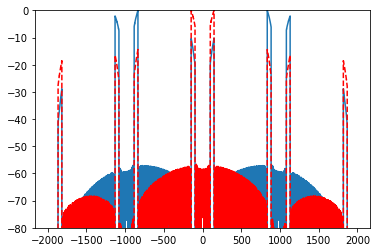

In [13]:
NyqZones = 4
rf = np.concatenate([np.ones(int(NyqZones/2)), -1.0*np.ones(int(NyqZones/2))])
xr_rf = np.convolve(rf, xr_upsampled)
XrrfdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xr_rf))))
freqs_rf = (np.arange(N*M*len(rf))/(N*M*len(rf)) - 0.5) * M*fs*len(rf)/1e6
plt.plot(freqs_rf, XrrfdB-np.max(XrrfdB))
plt.plot(freqs_nrz, XrnrzdB-np.max(XrnrzdB),'r--')
plt.ylim(-80,0);

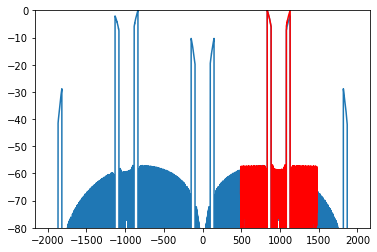

In [14]:
plt.plot(freqs_rf, XrrfdB-np.max(XrrfdB))
plt.plot(freqs+M*fs/1e6, XrdB-np.max(XrdB),'r')
plt.ylim(-80,0);

Text(0.5, 1.0, 'Spektar signala duplo vece ucestanosti')

<Figure size 864x432 with 0 Axes>

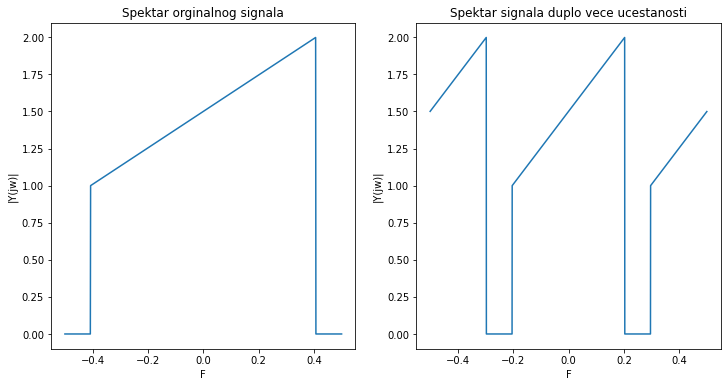

In [15]:
fs = 61.44e6
testsignal = readSamples("testsignal.txt")
N = len(testsignal)
plt.figure(figsize=(12, 6))
#posto radimo fft u broju tacaka koliko ima odbirka signala, onda mora biti toliko i pridruzenih  tacaka po x osi ffta
#freqs = (np.arange(N)/N - 0.5) * fs/1e6
F=(np.arange(N)/N - 0.5)

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(F, np.fft.fftshift(abs(np.fft.fft(testsignal))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar orginalnog signala")

M=2
oversampled_signal1 = np.zeros(len(testsignal)*M,dtype=complex) # argument dtype=complex je obavezan!
oversampled_signal1[::M] = testsignal
F1 = (np.arange(N*M)/(N*M) - 0.5) 

plt.subplot(1, 2, 2)

plt.plot(F1, np.fft.fftshift(abs(np.fft.fft(oversampled_signal1))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala duplo vece ucestanosti")



0.20345052083333334 0.29654947916666663


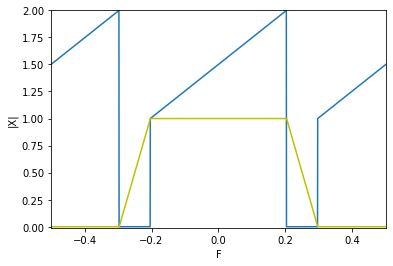

In [16]:
from remezlp import *

fmax = 25.0e6# iz zadatka 
fs = 61.44e6

Fpass = fmax/fs / M
Fx_max=0.5
Fstop = 2*Fx_max/M - Fpass
print(Fpass,Fstop)


plt.plot(F1, np.fft.fftshift(abs(np.fft.fft(oversampled_signal1))))
plt.plot([-M, -Fstop, -Fpass, Fpass, Fstop, M],[0, 0, 1, 1, 0, 0], 'y')
plt.xlabel("F")
plt.xlim(-0.5,0.5) 
plt.ylim(-0.01,2) 
plt.ylabel("|X|");

In [17]:
import scipy.signal
import numpy

def remezhb( Fpass, Astop, nPoints=8192, Nmax=200):
    """
    Design half band FIR filter with given specifications.
    """
    
    if (Fpass>0.25) or (Fpass<0.0):
        # Specifications are not valid
        return numpy.array([])
    
    remez = scipy.signal.remez
    freqz = scipy.signal.freqz
    
    # Filter order initial guess
    N = int(abs(Astop)/(23*(0.5-2*Fpass))/2)
    deltaPass = 10.0**(-abs(Astop)/20.0)
    # Scipy Remez uses number of taps instead of filter order.
    # Force even number of taps
    if N%2==1:
        N += 1
            
    while N<Nmax:
        # Design the filter.
        b = scipy.signal.remez(N, [0.0, 2*Fpass], [1], [1])
        
        # Check if filter meets specifications
        w, h = freqz(b, 1, worN = nPoints, fs=1)
        H = abs(h)
        specOK = True
        # Check specifications in pass band
        if numpy.sum(((w<2*Fpass)*abs(H-1.0))>2*deltaPass)>0:
            specOK = False
        if specOK:
            tmp = numpy.zeros(2*N-1)
            tmp[::2] = b
            tmp[N-1] = 1.0
            tmp = 0.5*tmp
            return tmp
        else:
            N += 2
    return []
    


In [18]:

def NextPass(F_previous,I):

    Fpass = F_previous/I
    return Fpass

def NextStop(Fx_max,F_pass,I):

    F_stop = 2*Fx_max/I - F_pass
    return F_stop


0.20345052083333334 0.10172526041666667 0.050862630208333336 0.025431315104166668
,0.29654947916666663 0.3982747395833333 0.4491373697916667 0.4745686848958333
,Red filtra:  38


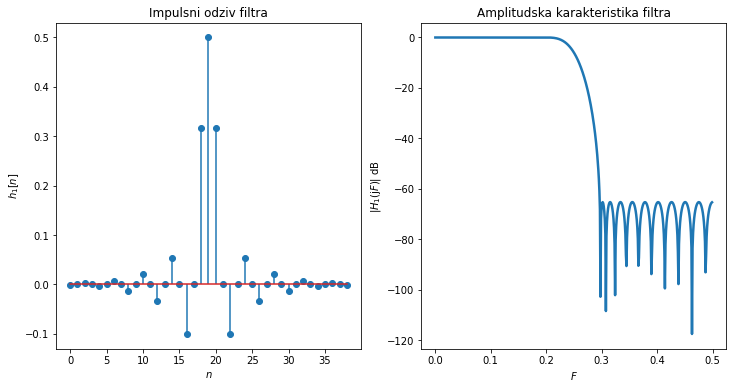

In [19]:
AdB = 60
I=2
#pravimo interpolator tako da svaki stepen ima povecanje broja odbirka za 2 
Fmax=fmax/fs
F1pass = NextPass(Fmax, I)
F2pass = NextPass(F1pass, I)
F3pass =NextPass(F2pass, I)
F4pass = NextPass(F3pass, I)

#stop vrednosti
F1stop = NextStop(0.5,F1pass, I)
F2stop =NextStop(0.5,F2pass, I)
F3stop = NextStop(0.5,F3pass, I)
F4stop =NextStop(0.5,F4pass, I)
print(F1pass,F2pass,F3pass,F4pass)
print(F1stop,F2stop,F3stop,F4stop)
#impulsni odziv filtra
h1 = remezhb(F1pass, AdB)

N1 = len(h1);
print("Red filtra: ", N1 - 1)

w,H1 = scipy.signal.freqz(h1)
#w su digitalne ucestanosti mi hocemo da ih normalizujemo pa ih delimo sa 2pi(tj predstavljamo grafik u formi relativne frekvencije)
#Plotovanje 
plt.figure(figsize=(12, 6))

# Orginalni signal
plt.subplot(1, 2, 1)

#plotovanje impulsnog odziva
plt.stem(h1)
plt.xlabel("$n$")
plt.ylabel("$h_1[n]$");
plt.title("Impulsni odziv filtra");

# Amplitudska karakteristika
plt.subplot(1, 2, 2)
plt.plot(w/(2*np.pi),20*np.log10(np.absolute(H1)), aa=True, linewidth=2.5)
plt.xlabel(r'$F$')
plt.ylabel(r'$|H_1(\mathrm{j} F)|~\mathrm{dB}$')
plt.title("Amplitudska karakteristika filtra");



Text(0.5, 1.0, 'Spektar filtriranog signal 2 puta vece ucestanosti odabiranja')

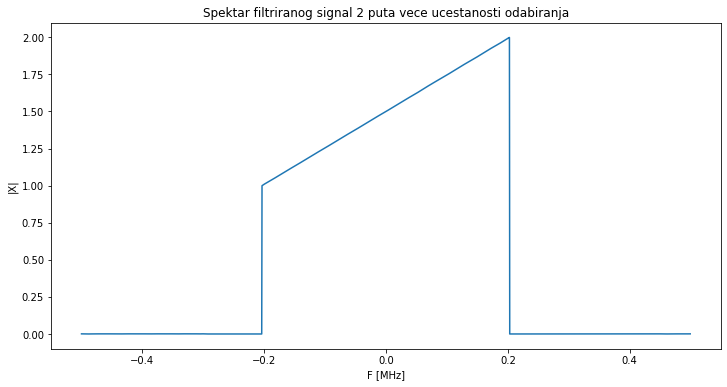

In [20]:
plt.figure(figsize=(12, 6))

oversampled_signal_temp= np.concatenate((oversampled_signal1, oversampled_signal1[0:int(len(h1))]))
xi = signal.lfilter(h1, 1, oversampled_signal_temp)
xi = xi[len(h1):]
plt.plot(F1, np.fft.fftshift(abs(np.fft.fft(xi))))
plt.xlabel("F [MHz]")
plt.ylabel("|X|");
plt.title("Spektar filtriranog signal 2 puta vece ucestanosti odabiranja")
# u realnom signalu ovo se vidi kao interpolirani signal tackama izmedju onih prvobitnih odbiraka umetnuti su novi koji su proizvod interpolacije 

Text(0.5, 1.0, 'Spektar signala 4 puta vece ucestanosti odabiranja')

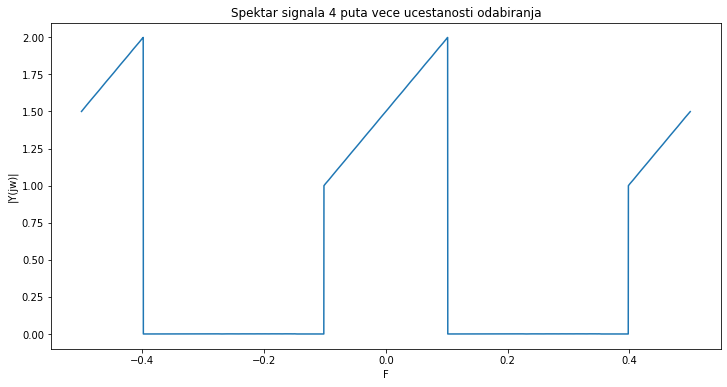

In [21]:

M=2
N = len(xi)
oversampled_signal2 = np.zeros(len(xi)*M,dtype=complex) # argument dtype=complex je obavezan!
oversampled_signal2[::M] = xi
F2 = (np.arange(N*M)/(N*M) - 0.5) 

plt.figure(figsize=(12, 6))


plt.plot(F2, np.fft.fftshift(abs(np.fft.fft(oversampled_signal2))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 4 puta vece ucestanosti odabiranja")

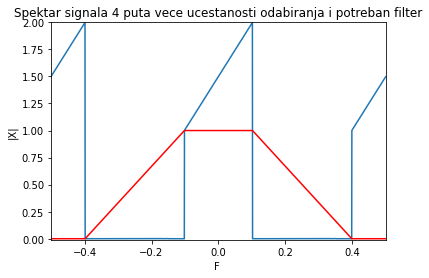

In [22]:
plt.plot(F2, np.fft.fftshift(abs(np.fft.fft(oversampled_signal2))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 4 puta vece ucestanosti odabiranja i potreban filter")
plt.plot([-1, -F2stop, -F2pass, F2pass, F2stop, 1],[0, 0, 1, 1, 0, 0], 'r')
plt.xlabel("F ")
plt.xlim(-0.5,0.5) 
plt.ylim(-0.01,2) 
plt.ylabel("|X|");


Red filtra:  10
,[ 0.00988884  0.         -0.05846894  0.          0.29878434  0.5
,  0.29878434  0.         -0.05846894  0.          0.00988884]


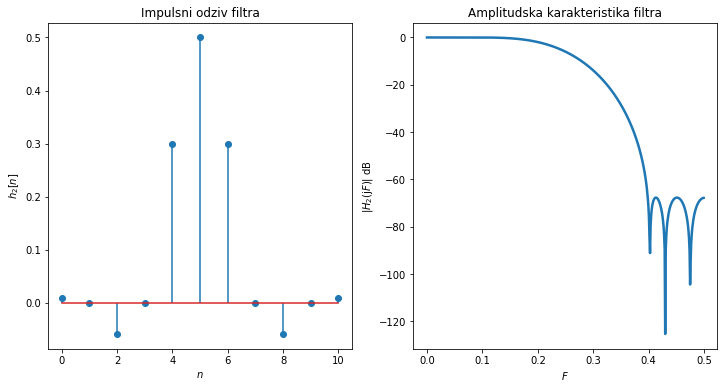

In [23]:
h2 = remezhb(F2pass, AdB)
#red filtra
N2 = len(h2);
print("Red filtra: ", N2 - 1)

#Amplitudska karakteristika filtra
w,H2 = scipy.signal.freqz(h2)

#Plotovanje 
plt.figure(figsize=(12, 6))

# Orginalni signal
plt.subplot(1, 2, 1)

#plotovanje impulsnog odziva
plt.stem(h2)
plt.xlabel("$n$")
plt.ylabel("$h_2[n]$");
plt.title("Impulsni odziv filtra");

# Amplitudska karakteristika
plt.subplot(1, 2, 2)
plt.plot(w/(2*np.pi),20*np.log10(np.absolute(H2)), aa=True, linewidth=2.5)
plt.xlabel(r'$F$')
plt.ylabel(r'$|H_2(\mathrm{j} F)|~\mathrm{dB}$')
plt.title("Amplitudska karakteristika filtra");
print(h2)

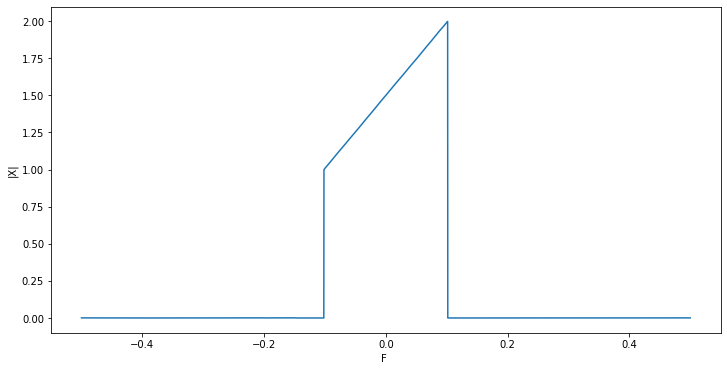

In [24]:
plt.figure(figsize=(12, 6))
# lfilter unosi fazno kasnjenje pa periodicnim produzenjem ulaznog signala dobijamo da ne moramo koristiti prozorske funkcije jer nema curenja sprektra
oversampled_signal_temp = np.concatenate((oversampled_signal2, oversampled_signal2[0:int(len(h2))-1]))
x2 = signal.lfilter(h2, 1, oversampled_signal_temp)
x2 = x2[len(h2)-1:]
plt.plot(F2, np.fft.fftshift(abs(np.fft.fft(x2))))
plt.xlabel("F ")
plt.ylabel("|X|");


Text(0.5, 1.0, 'Spektar signala 8 puta vece ucestanosti')

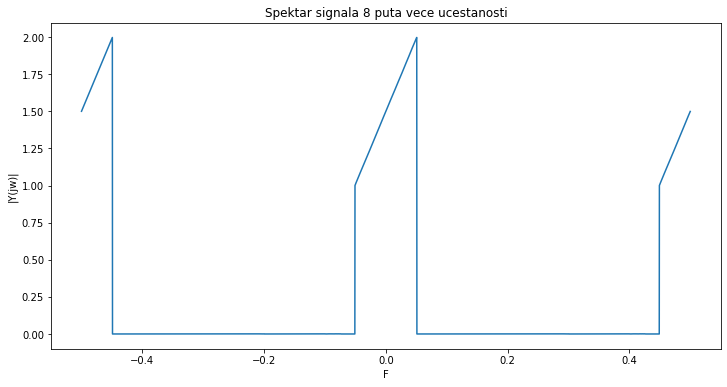

In [25]:
M=2
N = len(x2)
oversampled_signal3 = np.zeros(len(x2)*M,dtype=complex) # argument dtype=complex je obavezan!
oversampled_signal3[::M] = x2
F3 = (np.arange(N*M)/(N*M) - 0.5) 

plt.figure(figsize=(12, 6))


plt.plot(F3, np.fft.fftshift(abs(np.fft.fft(oversampled_signal3))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 8 puta vece ucestanosti")

(-0.01, 2.0)

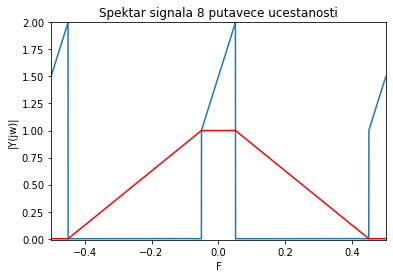

In [26]:
plt.plot(F3, np.fft.fftshift(abs(np.fft.fft(oversampled_signal3))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 8 putavece ucestanosti")
plt.plot([-1, -F3stop, -F3pass, F3pass, F3stop, 1],[0, 0, 1, 1, 0, 0], 'r')

plt.xlim(-0.5,0.5) 
plt.ylim(-0.01,2) 



Red filtra:  6
,[-0.03375513  0.          0.28363308  0.5         0.28363308  0.
, -0.03375513]


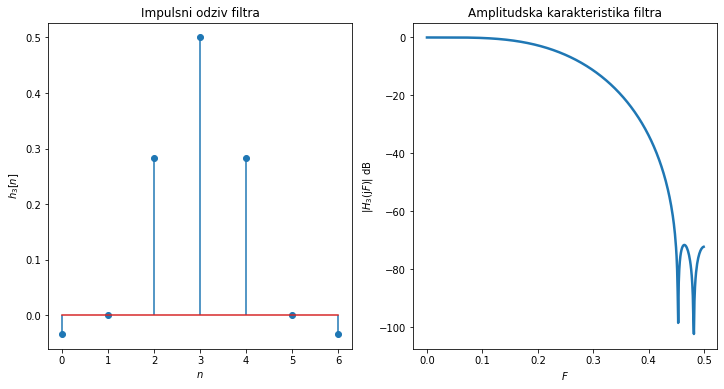

In [27]:
h3 = remezhb(F3pass, AdB)
#red filtra
N3 = len(h3);
print("Red filtra: ", N3 - 1)

w,H3 = scipy.signal.freqz(h3)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.stem(h3)
plt.xlabel("$n$")
plt.ylabel("$h_3[n]$");
plt.title("Impulsni odziv filtra");

plt.subplot(1, 2, 2)
plt.plot(w/(2*np.pi),20*np.log10(np.absolute(H3)), aa=True, linewidth=2.5)
plt.xlabel(r'$F$')
plt.ylabel(r'$|H_3(\mathrm{j} F)|~\mathrm{dB}$')
plt.title("Amplitudska karakteristika filtra");
print(h3)

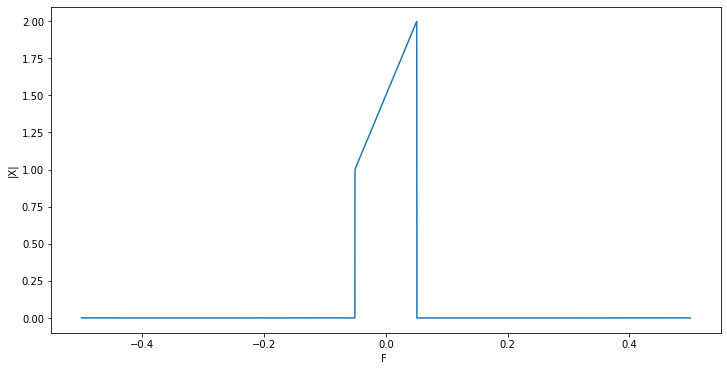

In [28]:
plt.figure(figsize=(12, 6))
oversampled_signal_temp = np.concatenate((oversampled_signal3, oversampled_signal3[0:int(len(h3))-1]))
x3 = signal.lfilter(h3, 1, oversampled_signal_temp)
x3 = x3[len(h3)-1:]
plt.plot(F3, np.fft.fftshift(abs(np.fft.fft(x3))))
plt.xlabel("F ")
plt.ylabel("|X|");

Text(0.5, 1.0, 'Spektar signala 16 puta vece ucestanosti')

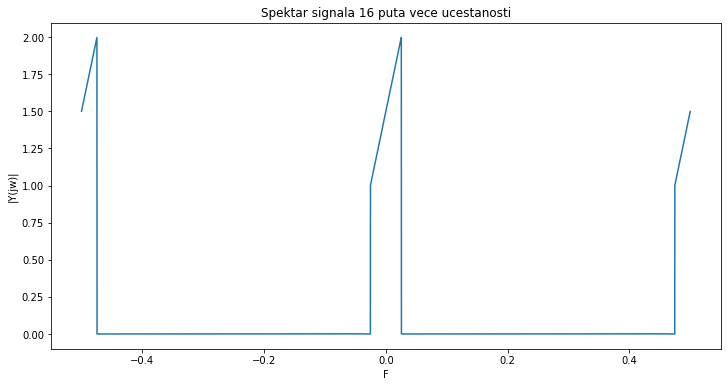

In [29]:
M=2
N = len(x3)
oversampled_signal4 = np.zeros(len(x3)*M,dtype=complex) # argument dtype=complex je obavezan!
oversampled_signal4[::M] = x3
F4 = (np.arange(N*M)/(N*M) - 0.5) 

plt.figure(figsize=(12, 6))


plt.plot(F4, np.fft.fftshift(abs(np.fft.fft(oversampled_signal4))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 16 puta vece ucestanosti")

(-0.01, 2.0)

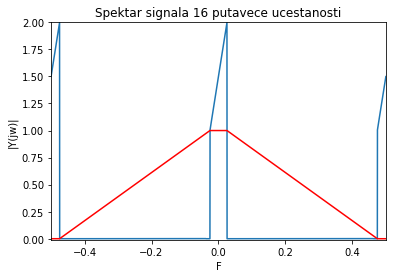

In [30]:
plt.plot(F4, np.fft.fftshift(abs(np.fft.fft(oversampled_signal4))))
plt.xlabel("F")
plt.ylabel("|Y(jw)|");
plt.title("Spektar signala 16 putavece ucestanosti")
plt.plot([-1, -F4stop, -F4pass, F4pass, F4stop, 1],[0, 0, 1, 1, 0, 0], 'r')

plt.xlim(-0.5,0.5) 
plt.ylim(-0.01,2) 


Red filtra:  6
,[-0.03185523  0.          0.28184798  0.5         0.28184798  0.
, -0.03185523]


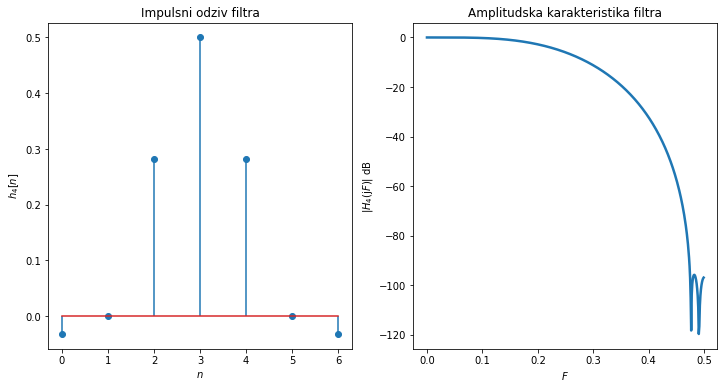

In [31]:
h4 = remezhb(F4pass, AdB)
#red filtra
N4 = len(h4);
print("Red filtra: ", N4 - 1)

#Amplitudska karakteristika filtra
w,H4 = scipy.signal.freqz(h4)

#Plotovanje 
plt.figure(figsize=(12, 6))

# Orginalni signal
plt.subplot(1, 2, 1)

#plotovanje impulsnog odziva
plt.stem(h4)
plt.xlabel("$n$")
plt.ylabel("$h_4[n]$");
plt.title("Impulsni odziv filtra");

# Amplitudska karakteristika
plt.subplot(1, 2, 2)
plt.plot(w/(2*np.pi),20*np.log10(np.absolute(H4)), aa=True, linewidth=2.5)
plt.xlabel(r'$F$')
plt.ylabel(r'$|H_4(\mathrm{j} F)|~\mathrm{dB}$')
plt.title("Amplitudska karakteristika filtra");
print(h4)

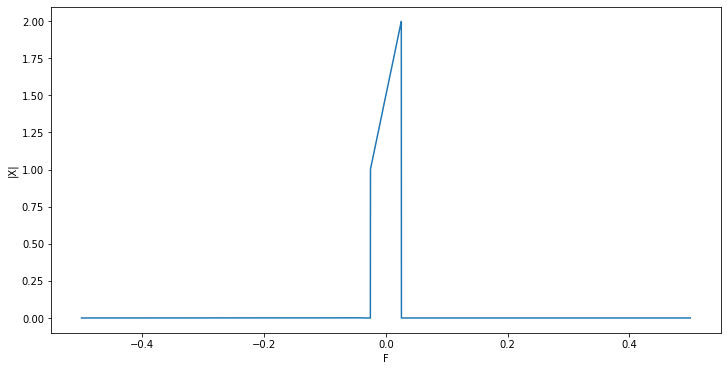

In [32]:
plt.figure(figsize=(12, 6))
oversampled_signal_perext = np.concatenate((oversampled_signal4, oversampled_signal4[0:int(len(h4))]))
x4 = signal.lfilter(h4, 1, oversampled_signal_perext)
x4 = x4[len(h4):]
plt.plot(F4, np.fft.fftshift(abs(np.fft.fft(x4))))
plt.xlabel("F")
plt.ylabel("|X|");

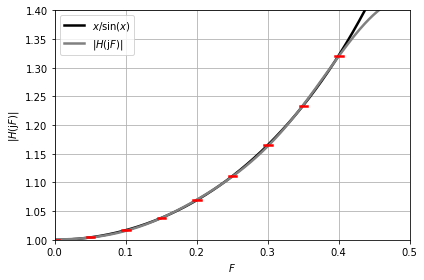

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import *
fmax = 0.4 # max. frequency of interest
n = 8 # number of points for approximation
f = fmax * np.arange(0, n+1, 1)/n
H_sinc = np.sin(np.pi*f)/(np.pi*f+1e-15)
H_sinc[0] = 1.0
f_goal = np.zeros(2*(n+1))
f_goal[0::2] = f
f_goal[1::2] = f+1e-3
f_goal *= 2	# In firls function Nyquist frequency is 1
goal = np.zeros(2*(n+1))
goal[0::2] = 1.0/H_sinc
goal[1::2] = 1.0/H_sinc
h_invsinc = firls(9, f_goal, goal)
w,H = freqz(tuple(h_invsinc),tuple([1]))
H_sinc = np.sin(w/2)/(w/2+1e-15)
H_sinc[0] = 1.0
plt.plot(w/(2*np.pi),np.absolute(1.0/H_sinc), 'k', aa=True, linewidth=2.5,label=r'$x/\sin(x)$')
plt.plot(w/(2*np.pi),np.absolute(H), 'gray', aa=True, linewidth=2.5,label=r'$|H(\mathrm{j} F)|$')
plt.legend(loc='upper left')
df = 0.005
for i in range(0,len(goal),2):
    plt.plot((f_goal[i]/2-df,f_goal[i+1]/2+df),[goal[i], goal[i+1]], 'r',aa=True, linewidth=2.5)
plt.xlim(0,0.5)
plt.ylim(1,1.4)
plt.grid()
plt.xlabel(r'$F$')
plt.ylabel(r'$|H(\mathrm{j} F)|$')
plt.tight_layout()
plt.show()

Normalized sinc correction filter
,[ 0.00170522 -0.00583712  0.01786389 -0.06833815  0.81251125 -0.06833815
,  0.01786389 -0.00583712  0.00170522]


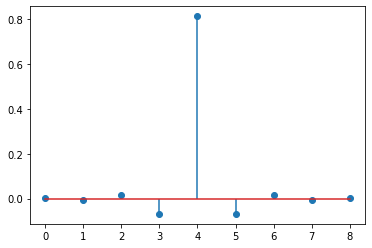

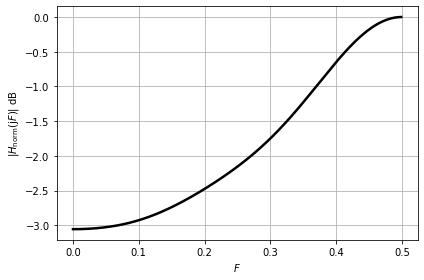

In [34]:
# Normalize invsinc filter coefficients
x = -1.0*np.ones(9)
x[0::2] = 1
h_invsinc_norm = h_invsinc / np.sum(h_invsinc*x)
print("Normalized sinc correction filter")
print(h_invsinc_norm)
plt.stem(h_invsinc_norm)
plt.show()
w,H = freqz(tuple(h_invsinc_norm),tuple([1]))
plt.plot(w/(2*np.pi),20*np.log10(np.absolute(H)), 'k', aa=True, linewidth=2.5)
plt.xlabel(r'$F$')
plt.ylabel(r'$|H_\mathrm{norm}(\mathrm{j} F)|~\mathrm{dB}$')
plt.grid()

plt.tight_layout()
plt.show()

[ 0.00170522 -0.00583712  0.01786389 -0.06833815  0.81251125 -0.06833815
,  0.01786389 -0.00583712  0.00170522]


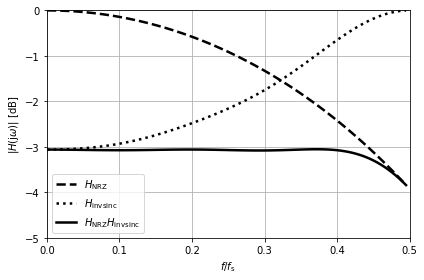

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import *
logScale = False
def fn_nrz(f):
    T = 1
    i=0
    a = np.pi*f*T
    v = np.sin(a+1e-15)/(a+1e-15)
    if logScale:
        g = 20*np.log10(abs(v))
    else:
        g = abs(v)
    return g
f = np.arange(0,0.5,0.005)
H_dac = fn_nrz(f) 
plt.plot(f, 20*np.log10(H_dac), '--k', linewidth=2.5,aa=True, label=r'$H_\mathrm{NRZ}$')
w, H_invsinc = freqz(h_invsinc_norm, 1, 2*np.pi*f)
H_invsinc_dB = 20*np.log10(np.absolute(H_invsinc))
plt.plot(f, H_invsinc_dB, ':k', linewidth=2.5,aa=True, label=r'$H_\mathrm{invsinc}$')
H_total = H_dac * H_invsinc
H_total_dB = 20*np.log10(np.absolute(H_total))
plt.plot(f, H_total_dB, '-k', linewidth=2.5,aa=True, label=r'$H_\mathrm{NRZ} H_\mathrm{invsinc}$')
plt.xlabel(r'$f/f_\mathrm{s}$')
plt.ylabel(r'$|H(\mathrm{j}\omega)|~\mathrm{[dB]}$')
print(h_invsinc_norm)
plt.legend(loc="lower left")
plt.xlim(0,0.5)
plt.ylim(-5,0)
plt.grid()
plt.tight_layout()
plt.show()

DRUGA FAZA PROJEKTA 

Text(0.5, 0, 'F')

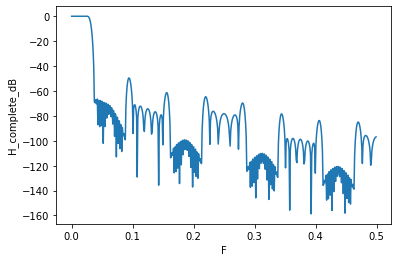

In [36]:
# zbog plemenitih identiteta prilikom premestanja mesta povecanju ucestanosti i filterskoj funckiji H(z)->H(z^2)
h1_oversempled= np.zeros(len(h1)*8)
h1_oversempled[::8] = h1

h2_oversempled= np.zeros(len(h2)*4)
h2_oversempled[::4] = h2

h3_oversempled= np.zeros(len(h3)*2)
h3_oversempled[::2] = h3

w1,H1_oversempled = scipy.signal.freqz(h1_oversempled)
w2,H2_oversempled= scipy.signal.freqz(h2_oversempled)
w3,H3_oversempled= scipy.signal.freqz(h3_oversempled)

H_complete=H1_oversempled*H2_oversempled*H3_oversempled*H4

H_complete_dB = 20*np.log10(np.absolute(H_complete))
plt.plot(w1/(2*np.pi), H_complete_dB)
plt.ylabel("H_complete_dB")
plt.xlabel(r'F')

In [37]:
def prerotation(x, y, z):

    if (z > np.pi / 2) and (z <= 3 * np.pi / 2):
        z_new = z - np.pi
        x_new = -x
        y_new = -y
        
    elif (z > 3 * np.pi / 2) and (z <= 2 * np.pi):
        z_new = z - 3 * np.pi / 2
        x_new = y
        y_new = -x
        
    else:
        x_new = x
        y_new = y
        z_new = z
        
    return x_new, y_new, z_new


In [38]:
def complex_mixer(x, y, M, N, B):

    x_copy = x
    y_copy = y

    x_n,y_n,z_n=np.zeros(M),np.zeros(M),np.zeros(M)
    z=0
        
    for i in range(M):
        z+=B
        
        # zbog prekoracenja
        if z >= 2 * np.pi:
            z -= 2 * np.pi
            
        x_copy[i] = x_copy[i] * CORDIC_Kn(N)
        y_copy[i] = y_copy[i] * CORDIC_Kn(N)
        

        x_tmp, y_tmp, z_tmp = prerotation(x_copy[i], y_copy[i], z)
    
        for j in range(N):
            if j < N - 1:
                x_tmp, y_tmp, z_tmp = CORDIC_iteration(x_tmp, y_tmp, z_tmp, j, "rotation")
            else:
                x_n[i], y_n[i], z_n[i] = CORDIC_iteration(x_tmp, y_tmp, z_tmp, j, "rotation")
    
    return x_n, y_n, z_n

Text(0.5, 0, 'F')

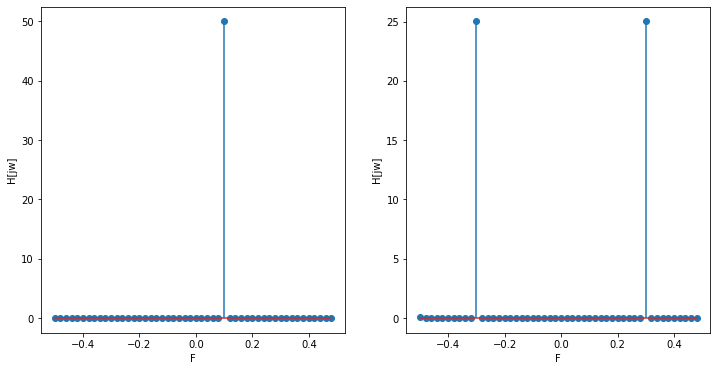

In [39]:
n=np.arange(0,50)
fs=50
f0=5
F=f0/fs

y=np.sin(2*np.pi*F*n)#2pi/10
x=np.cos(2*np.pi*F*n)
m=x+1j*y

freq = (n/len(n) - 0.5) 
# zeljena ucestanost koji prosledjujemo mesacu
W = 2*np.pi*(2*f0/fs) #pomerimo fazu za jos 2pi/5 =4pi/5 dakle F
#za koliko zelimo da pomerimo spektar( diskretni ugao)
B = W 


# odredili u prvoj fazi
N_cordic = 10

# primena kompleksnog mesaca
x_n, y_n, z_n = complex_mixer(x, y,len(x), N_cordic, B)

plt.figure(figsize=(12, 6))

# Orginalni signal
plt.subplot(1, 2, 1)
plt.ylabel("H[jw]")
plt.xlabel(r'F')

plt.stem(freq, np.fft.fftshift(abs(np.fft.fft(m))))

# prikaz sprektra
plt.subplot(1, 2, 2)
plt.stem(freq, np.fft.fftshift(abs(np.fft.fft(x_n))))
plt.ylabel("H[jw]")
plt.xlabel(r'F')



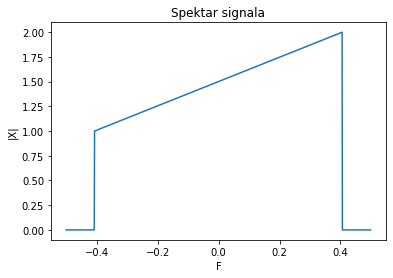

In [40]:
# Sampling frequency
fs = 61.44e6
#na osnovu fs mozemo zakljuciti da je granica prve nikvistove zone 30.72 MHz
#granice korisne zone je data u tekstu tj 25Mhz

# ucitavanje signala
testsignal = np.loadtxt("testsignal.txt", dtype=complex)

#duzina signala
N = len(testsignal)
#digitalne ucestanosti
freqs = (np.arange(N)/N - 0.5)

#Plotovanje spektara
plt.figure()

# Orginalni signal
plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(testsignal))))
plt.xlabel("F")
plt.ylabel("|X|");
plt.title("Spektar signala");

In [41]:
def makePolyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff)/M))
    tmp = np.zeros(n*M)
    tmp[:len(coeff)] = coeff
    polyCoeff = np.zeros((M,n))
    for i in range(M):
        polyCoeff[i,:] = tmp[i::M]
    return polyCoeff

def interp_polyphaze(x, h):
    FIRpoly = makePolyphase(h, 2)
    xpoly = np.zeros(len(x)*2, dtype = complex)
    for i in range(2):
        tmp,zi = scipy.signal.lfilter(FIRpoly[i], 1.0, x,zi=np.zeros(len(FIRpoly[i])-1))
        tmp,zi = scipy.signal.lfilter(FIRpoly[i], 1.0, x,zi=zi)
        xpoly[i::2] = tmp
    return xpoly    

In [42]:
# realni i imaginarni deo signala
x_real = testsignal.real
x_imag = testsignal.imag
# prva faza

x_phase1_poly_real = interp_polyphaze(x_real, h1)
x_phase1_poly_imag = interp_polyphaze(x_imag, h1)
x_phase2_poly_real = interp_polyphaze(x_phase1_poly_real, h2)
x_phase2_poly_imag = interp_polyphaze(x_phase1_poly_imag, h2)
# treca faza 
x_phase3_poly_real = interp_polyphaze(x_phase2_poly_real, h3)
x_phase3_poly_imag = interp_polyphaze(x_phase2_poly_imag, h3)
# cetvrta faza 
x_phase4_poly_real = interp_polyphaze(x_phase3_poly_real, h4)
x_phase4_poly_imag = interp_polyphaze(x_phase3_poly_imag, h4)

1024 16384


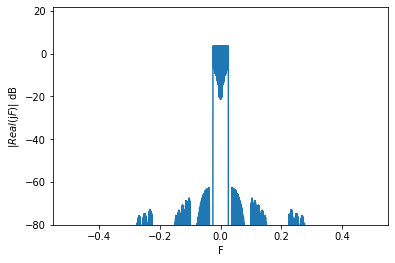

In [43]:

plotSpectrumdB(x_phase4_poly_real, xlabel = "F", ylabel = "$|Real(\mathrm{j} F)|~\mathrm{dB}$", show=False)
print(len(testsignal),len(x_phase4_poly_real))

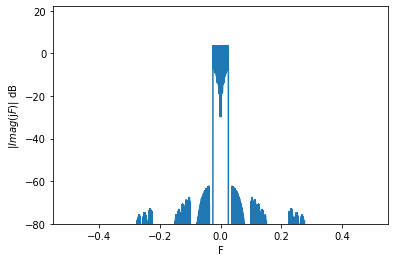

In [44]:
# imaginarni deo00.0
plotSpectrumdB(x_phase4_poly_imag, xlabel = "F", ylabel = "$|Imag(\mathrm{j} F)|~\mathrm{dB}$", show=False)
#m=x_phase4_poly_real+1j*x_phase4_poly_imag
#plotSpectrumdB(m, xlabel = "F", ylabel = "$|Himag(\mathrm{j} F)|~\mathrm{dB}$", show=False)

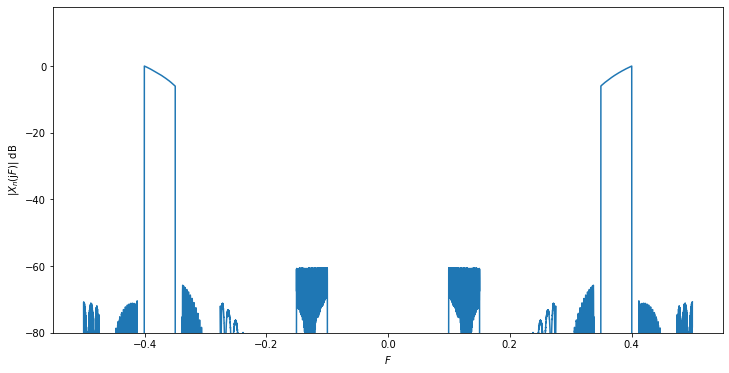

In [45]:

I=16
fs_new=I*fs
f0=3*fs_new/8
# zeljena ucestanost koji prosledjujemo mesacu
W = 2*np.pi*(f0/fs_new) #pomerimo za deltaF=3/8
B = W 

# odredjeno u prvoj fazi projekta
N_cordic = 10

x_n, y_n, z_n = complex_mixer(x_phase4_poly_real, x_phase4_poly_imag,len(x_phase4_poly_imag), N_cordic, B)

plt.figure(figsize=(12, 6))


# Orginalni sign
plotSpectrumdB(x_n, xlabel = "$F$", ylabel="$|X_{n}(\mathrm{j} F)|~\mathrm{dB}$", show=True, limit = -80)

[ 0.00170522 -0.00583712  0.01786389 -0.06833815  0.81251125 -0.06833815
,  0.01786389 -0.00583712  0.00170522]


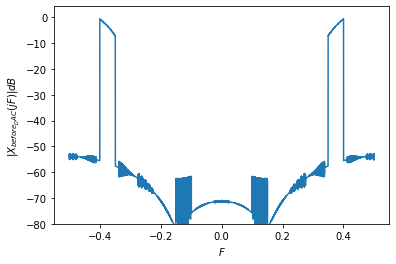

In [46]:
# primena kompenzacionog filtra
print(h_invsinc_norm)
x_comp = np.convolve(x_n, h_invsinc_norm)
x_comp = x_comp[len(h_invsinc_norm)-1:]

plotSpectrumdB(x_comp, r'$F$', r'|$X_{before_DAC}(jF)|dB$')



16384


(-40.0, 0.0)

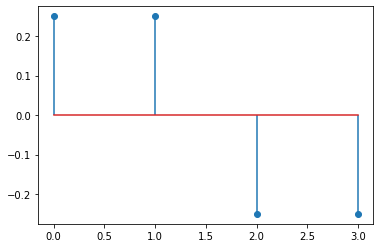

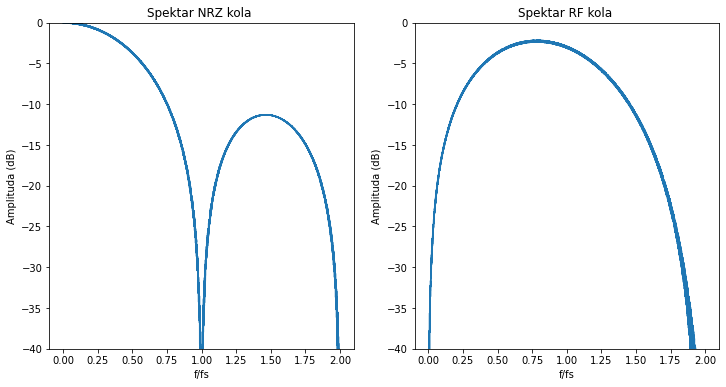

In [47]:

N = 16384 # number of data points
M = 4  # oversample factor
# Generate random numbers to get flat spectrum
phase = np.random.uniform(-np.pi,np.pi,N)
Y = np.ones(int(N),dtype=complex) * np.exp(1j*phase)
y = np.fft.ifft(Y)
nrz = 1.0*np.ones((1, M))[0]/(1.0*M)
x = np.arange(0, int(N/2), 1)/N*M
rf = 1.0*np.ones((1, M))[0]/(1.0*M)
rf[int(M/2):] = -rf[int(M/2):]
plt.stem(rf)
yr_nrz = lfilter(nrz, 1.0, y)
yr_rf = lfilter(rf, 1.0, y)

Yr_nrz = 20*np.log10(np.absolute(np.fft.fft(yr_nrz)))
Yr_rf = 20*np.log10(np.absolute(np.fft.fft(yr_rf)))
plt.figure(figsize=(12, 6))

# Orginalni signal
plt.subplot(1, 2, 1)
plt.plot(x,Yr_nrz[0:int(N/2)])
plt.xlabel('f/fs')
plt.ylabel('Amplituda (dB)')
plt.title('Spektar NRZ kola ')

plt.ylim(-40,0)
print(len(yr_rf))
plt.subplot(1, 2, 2)
plt.xlabel('f/fs')
plt.ylabel('Amplituda (dB)')
plt.title('Spektar RF kola ')
plt.plot(x,Yr_rf[0:int(N/2)])
plt.ylim(-40,0)


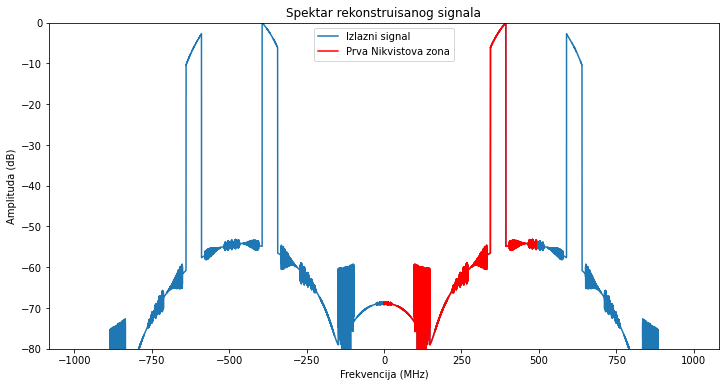

In [48]:
# Definisanje parametara
I = 16  # Faktor za upsampling
fs = 61.44 * 1e6  # Frekvencija uzorkovanja u Hz
N = len(testsignal)
NyqZones = 2
nrz = np.ones(NyqZones)
xr_upsampled = np.zeros((len(x_comp)-1)*NyqZones+1)
xr_upsampled[::NyqZones] = x_comp
xr_nrz = np.convolve(nrz, xr_upsampled)
XrnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(xr_nrz))))
X_comp_dB= 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_comp))))

plt.figure(figsize=(12, 6))
freqs_nrz = (np.arange(N*I*NyqZones)/(N*I*NyqZones) - 0.5) * I*fs*NyqZones/1e6
freqs_s = (np.arange(N*I)/(N*I) - 0.5) * I*fs/1e6

start_freq = 0# Početak prve nikvistove zone
end_freq = 491.52# (fs*16)/(2*1e6
plt.plot(freqs_nrz, XrnrzdB- np.max(XrnrzdB), label='Izlazni signal')
highlight_indices = np.where((freqs_nrz >= start_freq) & (freqs_nrz <= end_freq))
plt.plot(freqs_nrz[highlight_indices], (XrnrzdB- np.max(XrnrzdB))[highlight_indices], 'red', label='Prva Nikvistova zona')

plt.ylim(-80,0);
plt.xlabel('Frekvencija (MHz)')
plt.ylabel('Amplituda (dB)')
plt.title('Spektar rekonstruisanog signala')

plt.legend()
plt.show()

0.875


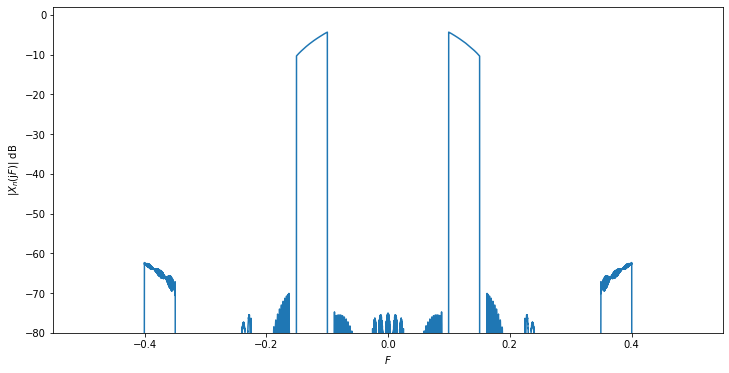

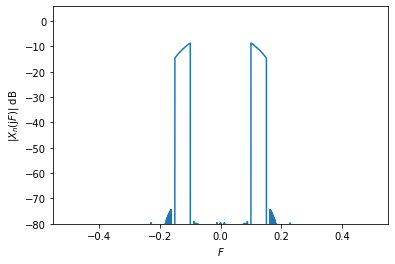

In [49]:
###### I=16
fs_new=I*fs
f0 = 860.16*1e6
# zeljena ucestanost koji prosledjujemo mesacu
W = 2*np.pi*(f0/fs_new) 

print(f0/fs_new)
B = W 

N_cordic = 10
x_n, y_n, z_n = complex_mixer(x_phase4_poly_real, x_phase4_poly_imag,len(x_phase4_poly_imag), N_cordic, B)

plt.figure(figsize=(12, 6))


plotSpectrumdB(x_n, xlabel = "$F$", ylabel="$|X_{n}(\mathrm{j} F)|~\mathrm{dB}$", show=True, limit = -80)
# shiftovanje signala pomocu mnozenja kompleksnim blojem 
m=x_phase4_poly_real+1j*x_phase4_poly_imag
n = np.arange(len(x_phase4_poly_real))
freq_shift = np.exp(1j *W*n)


x_n_shifted = m * freq_shift
plotSpectrumdB(x_n_shifted.real, xlabel = "$F$", ylabel="$|X_{n}(\mathrm{j} F)|~\mathrm{dB}$", show=True, limit = -80)


## 

4


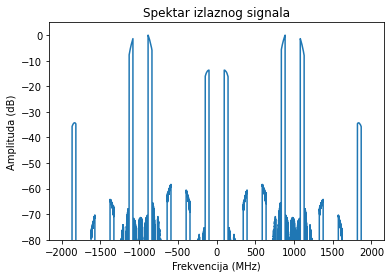

In [50]:
NyqZones = 4
#ako se upise obaj broj odbiraka kod kreiranja rf filtra vidimo da druga nikvostova najbolje propusta
xr_upsampled = np.zeros((len(x_n)-1)*NyqZones+1)
xr_upsampled[::NyqZones] = x_n
rf = np.concatenate([np.ones(int(NyqZones/2)), -1.0*np.ones(int(NyqZones/2))])
x_n_rf = np.convolve(rf, xr_upsampled)
XrrfdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_n_rf))))
freqs_rf = (np.arange(N*I*len(rf))/(N*I*len(rf)) - 0.5) * I*fs*len(rf)/1e6
print(len(rf))
plt.plot(freqs_rf, XrrfdB-np.max(XrrfdB))
plt.xlabel('Frekvencija (MHz)')
plt.ylabel('Amplituda (dB)')
plt.title('Spektar izlaznog signala')

plt.ylim(-80,5);


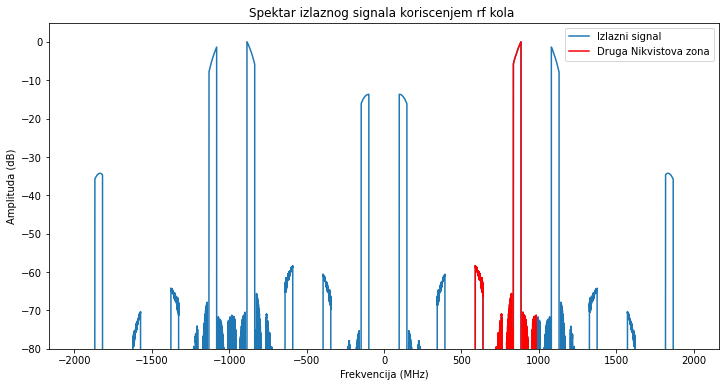

In [51]:
plt.figure(figsize=(12, 6))

start_freq = 491.52# Početak druge nikvistove zone
end_freq = 983.04# (fs*16)
plt.plot(freqs_rf, XrrfdB-np.max(XrrfdB), label='Izlazni signal')
highlight_indices = np.where((freqs_rf >= start_freq) & (freqs_rf <= end_freq))
plt.plot(freqs_rf[highlight_indices], XrrfdB[highlight_indices]-np.max(XrrfdB), 'r', label='Druga Nikvistova zona')

plt.ylim(-80,5);
plt.legend()
plt.xlabel('Frekvencija (MHz)')
plt.ylabel('Amplituda (dB)')
plt.title('Spektar izlaznog signala koriscenjem rf kola ')

plt.show()